# Forecasting with compotime

compotime is focused on forecasting compositional time series, that is, time series where the observations at each time point describe proportions or fractions of different components that make up a whole and add up to a constant sum.

In this example, we will forecast the popularity of programming languages using data from the [PYPL Popularity of Programming Language Index](https://pypl.github.io/PYPL.html). Data was retrieved from [kaggle](https://www.kaggle.com/datasets/muhammadkhalid/most-popular-programming-languages-since-2004) and transformed so that no additonal preprocessing is required.

## Input data

compotime uses `pd.DataFrame` objects for time series. Rows represent time indices, and columns represent the different shares (components).

The `DataFrame.index` is used to represent the time series index. `pd.Index`, `pd.RangeIndex`, `pd.DatetimeIndex` and `pd.PeriodIndex` are supported as long as all the values of the index are evenly spaced.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

<Axes: xlabel='Date'>

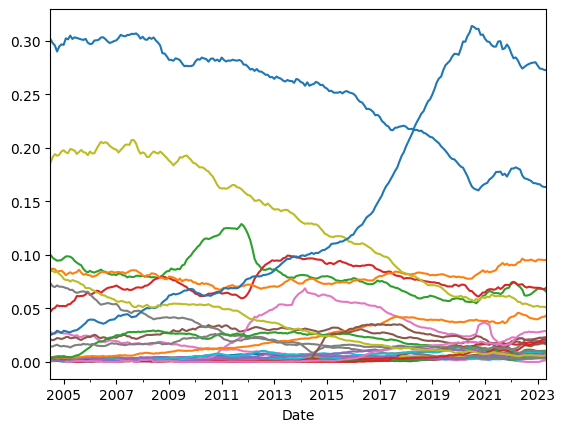

In [2]:
df = pd.read_csv("data/proglangpop.csv", converters={"Date": pd.Period}).set_index("Date")

df.plot(legend=False)

In [3]:
df.index

PeriodIndex(['2004-07', '2004-08', '2004-09', '2004-10', '2004-11', '2004-12',
             '2005-01', '2005-02', '2005-03', '2005-04',
             ...
             '2022-08', '2022-09', '2022-10', '2022-11', '2022-12', '2023-01',
             '2023-02', '2023-03', '2023-04', '2023-05'],
            dtype='period[M]', name='Date', length=227)

At each time index, the sum of all the values in the corresponding row should equal zero.

In [4]:
df.sum(axis=1).all()

True

It is not a requirement that the different individual time series start at the same time, which means that `NaN` values are valid in a given column as long as they are not preceded by any other values.

Next plot shows missing values in the time series. The yellow columns show missing values in the Dart, Go, Julia, Swift and Typescript programming languages, which did not exist at the beginning of the time series.

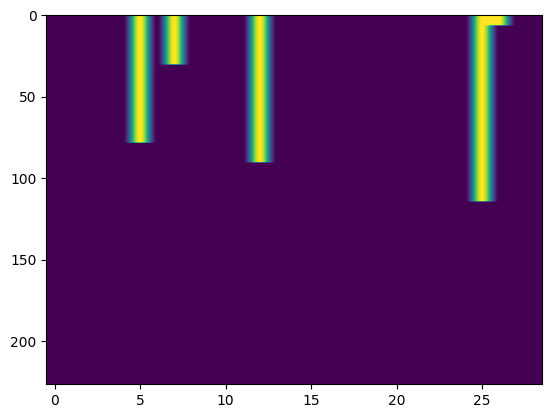

In [5]:
plt.imshow(df.isna(), aspect="auto")

The forecasters that are currently implemented apply an internal transformation so that the values of the time series are unbounded when the model is fitted. This transformation requires that all values are positive and not too close to zero to avoid numerical issues. The function `treat_small` ensures that all values in the time series are not smaller than the given minimum while preserving the sum one constraint.

In [6]:
from compotime.preprocess import treat_small

df = treat_small(df, 1e-3)

## Specifying the forecasting algorithm

At the moment, two different models are available: the `LocalLevelForecaster` and the `LocalTrendForecaster`. 

The `LocalLevelForecaster` is a very basic model that is only capable of forecasting constant values, whereas the `LocalTrendForecaster` is more flexible.

The interface of the models is similar to the one used in `scikit-learn`.

In [7]:
from compotime.models import LocalTrendForecaster

forecaster = LocalTrendForecaster()

## Fitting the forecaster to the observed data

We will use data before 2019 to fit the model and keep the rest to check the quality of the forecasts.

In [8]:
cutoff = "2019-01"
train, test = df[df.index < cutoff], df[df.index >= cutoff]

Now we can fit the model:

In [9]:
forecaster.fit(train)

## Computing forecasts

Finally, we compute forecasts by providing an `horizon`, which represents the number of steps to be forecasted.

In [10]:
horizon = len(test)
forecasts = forecaster.predict(horizon)

Next plot shows the real time series, the fitted curve and the forecasts.

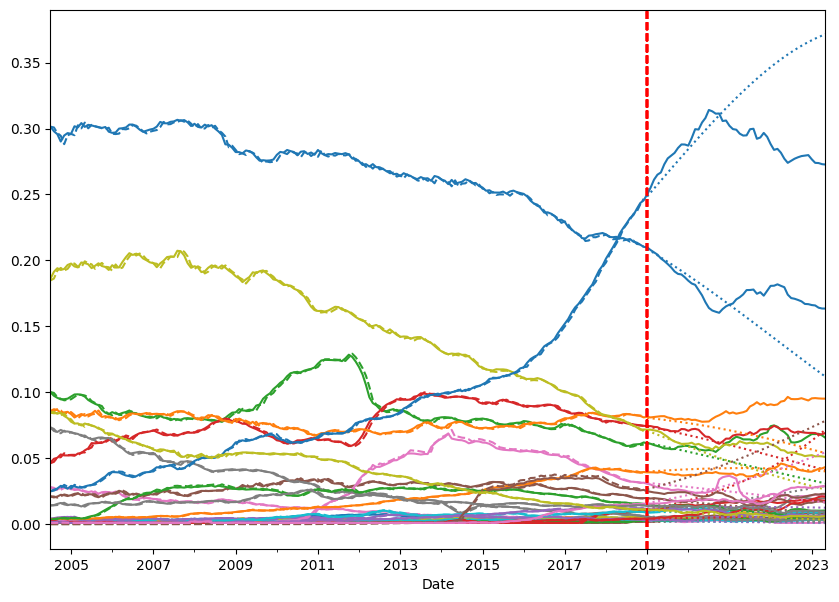

In [11]:
# Function to plot the time series
def plot_time_series(
    time_series: pd.DataFrame,
    fitted_curve: pd.DataFrame,
    predictions: pd.DataFrame,
) -> None:
    num_series = time_series.shape[1]
    color_cycle = plt.rcParams["axes.prop_cycle"].by_key()["color"]
    colors = [color_cycle[i % len(color_cycle)] for i in range(num_series)]

    for i, (name, series) in enumerate(time_series.iloc[:, :num_series].items()):
        color = colors[i]
        series.plot(color=color, figsize=(10, 7), label=name)
        fitted_curve.iloc[:, i].plot(color=color, linestyle="--", label="")
        predictions.iloc[:, i].plot(color=color, linestyle=":", label="")

        plt.axvline(predictions.index[0], color="red", linestyle="--")

    plt.show()


plot_time_series(df, forecaster.fitted_curve_, forecasts)